<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# GA Capstone: Fake News Classifier

Author: Tan Kai Yong Alvin

# Notebook 2-3: Modeling (Neural Network: LSTM GloVe Word Embedding)

Despite achieving good accuracy result with models such as Logistic Regression, LGBM and SVM algorithms models, these models are trained on multiple word as separate inputs that are just word having no actual meaning as a sentence, and predicting the class it will give the output according to statistics without any reference to the meaning/ context, which may be crucial for classification of news.

**Long Short Term Memory (LSTM)**

In this section, Long Short Term Memory (LSTM) with GloVe word embedding will be applied to build models. Unlike the other models that we applied (e.g. LGBM, LR, and NB models), LSTM can factor in the sequence and meaning of the text and hence the context of the news article is considered for prediction.

LSTM stands for Long-Short Term Memory. LSTM is a type of recurrent neural network but is better than traditional recurrent neural networks in terms of memory. In LSTM we can use a multiple word string to find out the class to which it belongs. This is very helpful while working with Natural language processing. If we use appropriate layers of embedding and encoding in LSTM, the model will be able to find out the actual meaning in input string and will give the most accurate output class
[(Source)](https://medium.com/analytics-vidhya/classification-using-long-short-term-memory-glove-global-vectors-for-word-representation-254d02d5e158).

**GloVe Word Embedding**

GloVe stands for Global Vector for word representation. In this section,  GloVe word embedding will be applied to form a work embeffing layer in the model. The GloVe pretrained model used is trained on Wikipedia data with 6 billion tokens and a 400,000 word vocabulary ('glove.6B.100d.txt').

GloVe does not rely just on local statistics (local context information of words), but incorporates global statistics (word co-occurrence) to obtain word vectors.

## Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk

# sklearn imports
from sklearn.preprocessing import StandardScaler # we still need to scale, since this is still a NN, with a linear component, thus scaling is crucial
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
# NN imports
from tensorflow.keras.models import Sequential # to still build a NN model in a sequential pipeline
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Dropout, Dense, Embedding
from keras import Sequential
from keras.preprocessing import text, sequence

from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional
from tensorflow.keras.optimizers import Adam # we'll use the same optimizer: Adam
from tensorflow.keras.models import Sequential # Sequential class: creates NNs model in a sequential fashion
from tensorflow.keras.utils import to_categorical # to_categorical: does one hot encoding (same as sklearn onehotencoder used previously)
from tensorflow.keras.callbacks import EarlyStopping
# this setting widens how many characters pandas will display in a column:
pd.options.display.max_colwidth = 400

## Import

In [2]:
combined_df = pd.read_csv('./datasets/combined_df.csv')

## Preprocessing of Text

The pre-processing steps prior to application of LSTM Neural Network comprises of the following:

* Lower Case
* Remove URLs
* Remove punctuations
* Tokenization
* Drop stopwords

In order to retain the semantic meaning of the article and not affect the word embedding, neither Lemmitazation nor Stemming was performed as a preprocessing step 

In [3]:
combined_df['lower_case'] = combined_df['title_text'].str.lower()

In [4]:
# remove website addresses from selftext_title column
# instantiate regex to identify and remove urls
combined_df['drop_url'] = combined_df['lower_case'].apply(lambda text: re.sub(r"http\S+", '', text))

In [5]:
# remove punctuations
combined_df['drop_punctuations'] = combined_df['drop_url'].apply(lambda text: re.sub(r'[^\w\s]', '', text))

In [6]:
# tokenize
tokenizer = RegexpTokenizer(r"[\w']+") 
combined_df['tokenized'] = combined_df['drop_punctuations'].apply(lambda text: tokenizer.tokenize(text))

In [7]:
stopwords_list = stopwords.words("english")

# some words provided the source of the article, which may reveal explicitly if the news is fake or real.Such words will be omitted to make the model less bias towards source
add_stopwords = ["21wire", "twitter", "reuters", '21WIRE', '21st', 'Century',  'Wire', 'somodevilla', 'getty', 'images', 'subscribe', 'member', 'realdonaldtrump']
stopwords_list.extend(add_stopwords)

In [8]:
combined_df['classification_lstm']= combined_df['tokenized'].apply(lambda value: " ".join( [word for word in value if word not in stopwords_list]))

In [9]:
lstm_df = combined_df[['title_text', 'classification_lstm', 'label']]
lstm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44689 entries, 0 to 44688
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   title_text           44689 non-null  object
 1   classification_lstm  44689 non-null  object
 2   label                44689 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.0+ MB


## Modeling 

### Model 1 (1 Birectional LSTM layer and 1 unidirectional LSTM maxlen to 300) 

#### Create Word Embedding

In [10]:
# tokenize text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(lstm_df['classification_lstm'])
word_index = tokenizer.word_index
vocab_size = len(word_index)
vocab_size

227553

In [11]:
# padding data
# keep the maxlen to a reasonable number for machine to handle
sequences = tokenizer.texts_to_sequences(lstm_df['classification_lstm'])
#embedding_dim =100
padded_sequences = pad_sequences(sequences, maxlen =300, padding ='post', truncating ='post')

In [12]:
# create embedding index
embedding_index ={}
with open('glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype ='float32')
        embedding_index[word] = coefs

In [13]:
# create embedding matrix
embedding_matrix = np.zeros((vocab_size+1,100))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

#### Input Split

In [14]:
# Define training and testing sets. Train/test split.
X_train, X_test, y_train, y_test = train_test_split(padded_sequences,
                                                    lstm_df['label'],
                                                    test_size=0.25,
                                                    stratify=lstm_df['label'],
                                                    random_state=42)

In [15]:
X_train.shape

(33516, 300)

In [16]:
X_test.shape

(11173, 300)

#### Model Training

In [17]:
model1 = Sequential([
    Embedding(vocab_size+1, 100, input_length=300, weights =[embedding_matrix], trainable = False),
    Dropout(0.2),
    Bidirectional(LSTM(128, return_sequences = True)),
    Dropout(0.2),
    LSTM(64),
    Dense(32, activation='relu'),
    Dense(1, activation ='sigmoid')
])

In [18]:
model1.compile(loss ='binary_crossentropy', optimizer ='adam', metrics='accuracy')
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 100)          22755400  
                                                                 
 dropout (Dropout)           (None, 300, 100)          0         
                                                                 
 bidirectional (Bidirectiona  (None, 300, 256)         234496    
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 300, 256)          0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                82176     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                        

In [19]:
# Train model
callbacks = [EarlyStopping(monitor='val_loss')]
history = model1.fit(X_train, y_train, epochs =15, batch_size =256, validation_data =(X_test, y_test))

Epoch 1/15
131/131 [==============================] - 726s 6s/step - loss: 0.5355 - accuracy: 0.7152 - val_loss: 0.3104 - val_accuracy: 0.9022
Epoch 2/15
131/131 [==============================] - 788s 6s/step - loss: 0.2952 - accuracy: 0.8904 - val_loss: 0.2180 - val_accuracy: 0.9301
Epoch 3/15
131/131 [==============================] - 796s 6s/step - loss: 0.2012 - accuracy: 0.9259 - val_loss: 0.1808 - val_accuracy: 0.9327
Epoch 4/15
131/131 [==============================] - 787s 6s/step - loss: 0.1750 - accuracy: 0.9336 - val_loss: 0.1356 - val_accuracy: 0.9510
Epoch 5/15
131/131 [==============================] - 808s 6s/step - loss: 0.1339 - accuracy: 0.9506 - val_loss: 0.0990 - val_accuracy: 0.9646
Epoch 6/15
131/131 [==============================] - 824s 6s/step - loss: 0.0830 - accuracy: 0.9713 - val_loss: 0.0638 - val_accuracy: 0.9789
Epoch 7/15
131/131 [==============================] - 820s 6s/step - loss: 0.0605 - accuracy: 0.9792 - val_loss: 0.0457 - val_accuracy: 0.9852

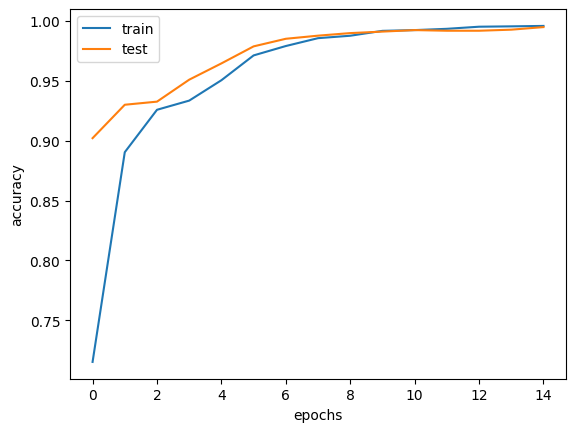

In [20]:
# plot 'accuracy'
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train', 'test'])
plt.show()

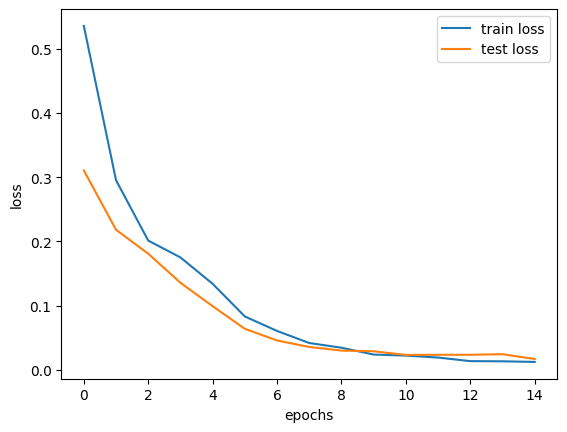

In [21]:
# plot for 'loss'
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train loss', 'test loss'])
plt.show()

### Model 2 (1 Birectional LSTM layer and 1 unidirectional LSTM, maxlen 200)

For Model 2, the maxlen of the text is reduced from 300 to 200.  This is to investigate if the performance of the model will improve when more text information is fed into the model for training.

The following observations were made:
* No significant reduction in performance as measured by the accuracy. Training and testing accuracy for model trained with maxlen =200 were comparable with that for the model trained with maxlen =300.
* Significant reduction in run time / computation effort while only achieving comparable scores. Train time per step increase from 5 to 7 seconds per step to 2 to 3 seconds per step. 

#### Create Word Embeddings

In [22]:
# tokenize text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(lstm_df['classification_lstm'])
word_index = tokenizer.word_index
vocab_size = len(word_index)
vocab_size

227553

In [23]:
# padding data
# keep the maxlen to a reasonable number for machine to handle
sequences = tokenizer.texts_to_sequences(lstm_df['classification_lstm'])
#embedding_dim =100
padded_sequences = pad_sequences(sequences, maxlen =200, padding ='post', truncating ='post')

In [24]:
# create embedding index
embedding_index ={}
with open('glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype ='float32')
        embedding_index[word] = coefs

In [25]:
# create embedding matrix
embedding_matrix = np.zeros((vocab_size+1,100))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [26]:
#embedding_matrix[1]

#### Input Split

In [27]:
#padded_seq[1]

In [28]:
# Define training and testing sets. Train/test split.
X_train, X_test, y_train, y_test = train_test_split(padded_sequences,
                                                    lstm_df['label'],
                                                    test_size=0.25,
                                                    stratify=lstm_df['label'],
                                                    random_state=42)

In [29]:
X_train.shape

(33516, 200)

In [30]:
X_test.shape

(11173, 200)

#### Model Training

In [31]:
model = Sequential([
    Embedding(vocab_size+1, 100, input_length=200, weights =[embedding_matrix], trainable = False),
    Dropout(0.2),
    Bidirectional(LSTM(128, return_sequences = True)),
    Dropout(0.2),
    LSTM(64),
    Dense(32, activation='relu'),
    Dense(1, activation ='sigmoid')
])

In [32]:
model.compile(loss ='binary_crossentropy', optimizer ='adam', metrics='accuracy')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 100)          22755400  
                                                                 
 dropout_2 (Dropout)         (None, 200, 100)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 200, 256)         234496    
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 200, 256)          0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                82176     
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                      

In [33]:
# Train model
callbacks = [EarlyStopping(monitor='val_loss')]
history = model.fit(X_train, y_train, epochs =15, batch_size =256, validation_data =(X_test, y_test))

Epoch 1/15
131/131 [==============================] - 345s 3s/step - loss: 0.4878 - accuracy: 0.7513 - val_loss: 0.4132 - val_accuracy: 0.8339
Epoch 2/15
131/131 [==============================] - 329s 3s/step - loss: 0.3158 - accuracy: 0.8806 - val_loss: 0.2214 - val_accuracy: 0.9274
Epoch 3/15
131/131 [==============================] - 338s 3s/step - loss: 0.2232 - accuracy: 0.9195 - val_loss: 0.1643 - val_accuracy: 0.9391
Epoch 4/15
131/131 [==============================] - 337s 3s/step - loss: 0.1427 - accuracy: 0.9455 - val_loss: 0.1068 - val_accuracy: 0.9640
Epoch 5/15
131/131 [==============================] - 338s 3s/step - loss: 0.0989 - accuracy: 0.9645 - val_loss: 0.0716 - val_accuracy: 0.9739
Epoch 6/15
131/131 [==============================] - 339s 3s/step - loss: 0.0641 - accuracy: 0.9769 - val_loss: 0.0544 - val_accuracy: 0.9803
Epoch 7/15
131/131 [==============================] - 336s 3s/step - loss: 0.0513 - accuracy: 0.9815 - val_loss: 0.0696 - val_accuracy: 0.9744

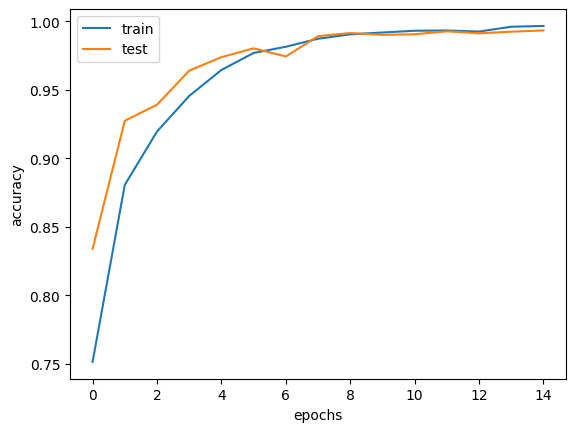

In [34]:
# plot 'accuracy'
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train', 'test'])
plt.show()

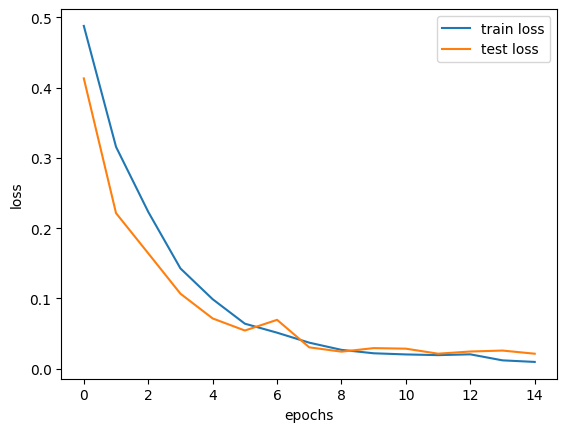

In [35]:
# plot for 'loss'
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train loss', 'test loss'])
plt.show()

Assessment
* Long Short Term Memory & GloVe Embeddings (model) to classify Text using Pre-trained Embeddings and Bidirectional LSTMs is able to generate accuracy performance of 0.995 (train) and 0.989 (test)

### Model 3 (2 layers of unidirectional LSTM)

#### Model Training

In [36]:
model1 = Sequential([
    Embedding(vocab_size+1, 100, input_length=200, weights =[embedding_matrix], trainable = False),
    Dropout(0.2),
    LSTM(128, return_sequences = True),
    Dropout(0.2),
    LSTM(64),
    Dense(32, activation='relu'),
    Dense(1, activation ='sigmoid')
])

In [37]:
model1.compile(loss ='binary_crossentropy', optimizer ='adam', metrics='accuracy')
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 200, 100)          22755400  
                                                                 
 dropout_4 (Dropout)         (None, 200, 100)          0         
                                                                 
 lstm_4 (LSTM)               (None, 200, 128)          117248    
                                                                 
 dropout_5 (Dropout)         (None, 200, 128)          0         
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 1)                

In [38]:
# Train model
callbacks = [EarlyStopping(monitor='val_loss')]
history = model1.fit(X_train, y_train, epochs =15, batch_size =256, validation_data =(X_test, y_test))

Epoch 1/15
131/131 [==============================] - 344s 3s/step - loss: 0.5585 - accuracy: 0.6904 - val_loss: 0.5316 - val_accuracy: 0.8274
Epoch 2/15
131/131 [==============================] - 296s 2s/step - loss: 0.6038 - accuracy: 0.6452 - val_loss: 0.4682 - val_accuracy: 0.8175
Epoch 3/15
131/131 [==============================] - 319s 2s/step - loss: 0.4895 - accuracy: 0.7825 - val_loss: 0.4806 - val_accuracy: 0.7782
Epoch 4/15
131/131 [==============================] - 313s 2s/step - loss: 0.4646 - accuracy: 0.7832 - val_loss: 0.4473 - val_accuracy: 0.7835
Epoch 5/15
131/131 [==============================] - 277s 2s/step - loss: 0.4498 - accuracy: 0.7923 - val_loss: 0.4240 - val_accuracy: 0.8094
Epoch 6/15
131/131 [==============================] - 278s 2s/step - loss: 0.3997 - accuracy: 0.8262 - val_loss: 0.3343 - val_accuracy: 0.8788
Epoch 7/15
131/131 [==============================] - 279s 2s/step - loss: 0.4396 - accuracy: 0.8280 - val_loss: 0.2854 - val_accuracy: 0.8962

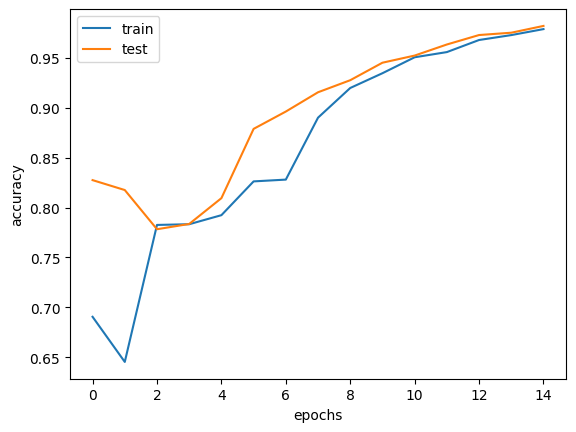

In [39]:
# plot 'accuracy'
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train', 'test'])
plt.show()

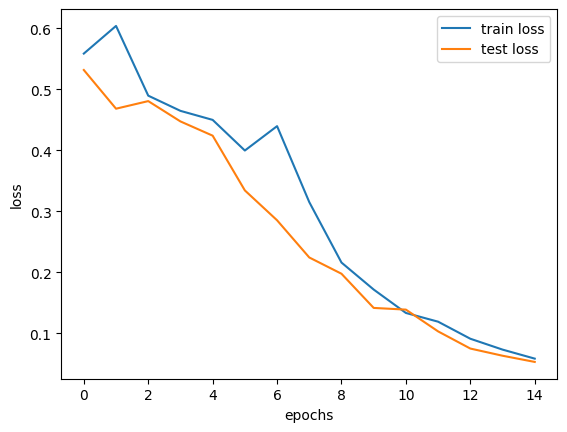

In [40]:
# plot for 'loss'
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train loss', 'test loss'])
plt.show()

## Validation with Independent (Unseen) Dataset

In [41]:
val_df = pd.read_csv('./datasets/val_df.csv')

In [42]:
val_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   title_text  1000 non-null   object
 1   label       1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


In [43]:
# lower case the text
val_df['lower_case'] = val_df['title_text'].str.lower()

In [44]:
# remove website addresses from selftext_title column
# instantiate regex to identify and remove urls
val_df['drop_url'] = val_df['lower_case'].apply(lambda text: re.sub(r"http\S+", '', text))

In [45]:
# remove punctuations
val_df['drop_punctuations'] = val_df['drop_url'].apply(lambda text: re.sub(r'[^\w\s]', '', text))

In [46]:
# tokenize
tokenizer = RegexpTokenizer(r"[\w']+") 
val_df['tokenized'] = val_df['drop_punctuations'].apply(lambda text: tokenizer.tokenize(text))

In [47]:
stopwords_list = stopwords.words("english")

# some words provided the source of the article, which may reveal explictly if the news is fake or real.Such words will be omitted to make the model less bias towards source
add_stopwords = ["21wire", "twitter", "reuters", '21WIRE', '21st', 'Century',  'Wire', 'somodevilla', 'getty', 'images', 'subscribe', 'member', 'realdonaldtrump']
stopwords_list.extend(add_stopwords)

In [48]:
val_df['classification_lstm']= val_df['tokenized'].apply(lambda value: " ".join( [word for word in value if word not in stopwords_list]))

In [49]:
X_val = val_df['classification_lstm']
y_val = val_df['label']

In [50]:
# tokenize text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_val)

In [51]:
# padding data
# keep the maxlen to a reasonable number for machine to handle
tokenized_val = tokenizer.texts_to_sequences(X_val)

X_val = pad_sequences(tokenized_val, maxlen =200, padding ='post', truncating ='post')

In [53]:
from sklearn.metrics import classification_report
unseen_pred = np.rint(model.predict([X_val], batch_size=1024, verbose=1)).astype('int')
print(classification_report(y_val, unseen_pred, target_names = ['Fake','Real']))

1/1 [==============================] - 2s 2s/step
              precision    recall  f1-score   support

        Fake       0.63      0.17      0.27       500
        Real       0.52      0.90      0.66       500

    accuracy                           0.54      1000
   macro avg       0.57      0.54      0.46      1000
weighted avg       0.57      0.54      0.46      1000



Poor performance on the unseen dataset.  This is likely due to inadequate data for the context learning to take place. 

## Summary of Modeling Performance


|Model|Transformer|Train Score (Accuracy)|Test Score (Accuracy)|Recall|
|:---------:|:--------------:|:----------:|:----------:|:----------:|
|  Multinomial Naive Bayes (Baseline)  |      Count Vectorizer     |   0.9505  | 0.9543  | -  |
|   Multinomial Naive Bayes (Hyperparameter Tuning) |      TF-IDF Vectorizer     |   0.9344  |   0.9359 | - |
|   Light Gradient Boosting Machine   |      Count  Vectorizer    |  0.9903  |   0.9931  |0.9935
|  Logistics Regression  |     Count Vectorizer   |   0.9847  |   0.9873  | 0.9889  |
|  SVM Linear Kernel |     Count Vectorizer   |   0.9838  |   0.9836  | 0.9851  |
|   LSTM (2 x LSTM layer, 1 word embedding layer: best accuracy)  |     GloVe Embedding    |   0.9960 |   0.9950  | - |

- **Count Vectorizer** vs TF-IDF Vectorizer. Count Vectorizer outperforms TF-IDF. In this case the number of occurrence represent the importance of word. More frequency means more importance. This is unsurprising in this context as real and fake news may be generated with it's own unique style of writing and choice of words. Hence, spotting the more frequent occurrence of certain words improves the prediction.

In this section, we will compare the performancce of the top 3 models identified.

- LSTM (with GloVe embedding) gives the best accuracy performance followed by Light Gradient Boosting Machine and Logistic Regression. All 3 models have accuracy of 0.99.

- **Light Gradient Boosting Machine"** model uses the tree based learning approach  but is able to achieve faster training speed and high efficiency with its leave wise tree growth approach. This model is able to achieve the best training- and testing scores with no overfitting

- **Logistic Regression** model was able to perform reasonably well. No overfitting observed as the differences in the train and test scores are relatively small. 

Overall, traditional machine learning models which adopts the bag of n-grams approach are able to perform reasonably well and they were also able to predict the unseen data set with fake news generated by the GPT-2 transformer accurately (~0.85). Logistic Regression model is the favoured model as it an efficient technique that dpes not require too many computational resources and is highly explainable.

In our exploration of **LSTM (with GloVe embedding)**, it was determined that a model with One word embedding layer(untrainable) and two LSTM layers (trainable) were able to predict with a similar high accuracy of 0.996. However, when it was used to predict the unseen data, accuracy had dropped to ~0.57.

- This may be potentially be attributed to the dataset being small and inadequate for neural network to be effectively applied. Since context is domain specific, inadequate dataset in each domain may result in the Bag of ngrams working better than neural network model as lack of data would means that you cannot find corresponding Vector from pre-trained word embedding models.

Based on the above justifications, **Logistic Regression** (with hyperparameter tuning) is selected as the best model.